In [1]:
try:
  import mat73
except:
  !pip install -q mat73
  import mat73

In [2]:
import os
import numpy as np
import numba as nb
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import gdown
import time
timestr = time.strftime("%Y-%m-%d_%H.%M.%S")

# DEFINE NECESSARY FUNCTIONS FOR PERFORMING HODMD

Related to HOSVD

In [3]:
def matlen(var):
    '''Equivalent to Matlab's length()'''
    if np.size(np.shape(var))==1:
        x = np.size(var)
    else:
        x = max(np.shape(var))
    return x

def unfold(A,dim):
    '''Turns tensor into matrix keeping the columns on dim'''
    ax=np.arange(A.ndim)
    return np.reshape(np.moveaxis(A,ax,np.roll(ax,dim)),(A.shape[dim],A.size//A.shape[dim]))


def fold(B,dim,shape):
    '''Reverse operation to the unfold function'''
    ax=np.arange(len(shape))
    shape=np.roll(shape,-dim)
    A=np.reshape(B,shape)
    return np.moveaxis(A,ax,np.roll(ax,-dim))

def tprod(S,U):
    '''Tensor product of an ndim-array and multiple matrices'''
    T = S
    shap = list(np.shape(S))
    for i in range(0,np.size(U)):
        x = np.count_nonzero(U[0][i])
        if not x==0:
            shap[i] = np.shape(U[0][i])[0]
            H = unfold(T,i)
            T = fold(np.dot(U[0][i],H),i,shap)
    return T

def svdtrunc(A, n):
    '''Truncated svd'''
    U, S, _ = randomized_svd(A, n_components = n)
    return U, S

def HOSVD_function(T,varepsilon1):
    '''Perform hosvd to tensor'''
    P = T.ndim
    U = np.zeros(shape=(1,P), dtype=object)
    UT = np.zeros(shape=(1,P), dtype=object)
    sv = np.zeros(shape=(1,P), dtype=object)
    producto = np.size(T)

    if isinstance(varepsilon1, (list, np.ndarray)):
        n = varepsilon1
    else:
        n = T.shape

    n = list(n)

    for i in range(0,P):
        n[i] = int(np.amin((n[i],producto/n[i])))
        A = unfold(T, i)

        Uaux = []
        # SVD based reduction of the current dimension (i):
        Ui, svi = svdtrunc(A, n[i])

        if n[i] < 2:
            Uaux = np.zeros((np.shape(Ui)[0],2))
            Uaux[:,0] = Ui[:,0]
            U[0][i] = Uaux
        else:
            if isinstance(varepsilon1, (list, np.ndarray)):
                pass
            else:
                count = 0
                for j in range(0,np.shape(svi)[0]):
                    if svi[j]/svi[0]<=varepsilon1:
                        pass
                    else:
                        count = count+1
                n[i] = count
            U[0][i] = Ui[:,0:n[i]]

        UT[0][i] = np.transpose(U[0][i])
        sv[0][i] = svi
    S = tprod(T, UT)
    TT = tprod(S, U)
    return TT, S, U, sv, n

def HOSVD(Tensor,varepsilon1,nn,n,TimePos):
    '''Perform hosvd to input data and retain all the singular values'''

    if np.iscomplex(Tensor.any()) == False:
        Tensor = Tensor.astype(np.float32)
    [TT,S2,U,sv,nn2] = HOSVD_function(Tensor,varepsilon1)
    ## Set the truncation of the singular values using varepsilon1
    # (automatic truncation)

    print(f'Initial number of singular values: {n}')
    print(f'Number of singular values retained: {nn2}')


    ## Construct the reduced matrix containing the temporal modes:
    UT = np.zeros(shape=np.shape(U), dtype=object)
    hatT = []
    for pp in range(0,np.size(nn2)):
        UT[0][pp] = np.transpose(U[0][pp])
    for kk in range(0,nn2[TimePos-1]):
        hatT.append(np.dot(sv[0][TimePos-1][kk],UT[0][TimePos-1][kk,:]))
    hatT = np.reshape(hatT, newshape=(len(hatT),np.size(hatT[0])))
    return hatT,U,S2,sv,nn2,n,TT

Related to DMD-1

In [4]:
def dmd1(V,t,esvd,edmd):
    '''First order dynamic modal decomposition:
        Input:
            -V (IxJ): Snapshot matrix.
            -t (J): Time vector.
            -esvd: First tolerance (SVD).
            -edmd: Second tolerance (DMD modes).
        Output:
            -u (Ixn): mode matrix (columns) sorted from biggest to smallest amplitude, put to scale.
            -areal (n): amplitude vector (sorted) used to put u to scale.
            -eigval: eigenvalues
            -delta (n): growth rate vector.
            -omega (n): frequency vector.
            -DMDmode: Modes'''
    dt=t[1]-t[0]

    # Reduced snapshots:
    U,s,Wh=truncatedSVD(V,esvd)
    Vvir=np.diag(s)@Wh
    n=s.size

    # Spatial complexity kk:
    NormS=np.linalg.norm(s,ord=2)
    kk=0
    for k in range(0,n):
        if np.linalg.norm(s[k:n],2)/NormS>esvd:
            kk=kk+1
    print(f'Spatial complexity: {kk}')

    # Koopman matrix reconstruction:
    Uvir,svir,Wvirh=np.linalg.svd(Vvir[:,:-1],full_matrices=False) #r'*r', r'*r', r'*(J-1)
    Rvir=Vvir[:,1:]@Wvirh.conj().T@np.diag(svir**-1)@Uvir.conj().T #r'*r'
    eigval,eigvec=np.linalg.eig(Rvir) #r'*r'

    # Frequencies and Growthrate:
    delta=np.log(eigval).real/dt #r'
    omega=np.log(eigval).imag/dt #r'

    # Amplitudes:
    A=np.zeros((eigvec.shape[0]*Vvir.shape[1],eigvec.shape[1]))
    b=np.zeros(eigvec.shape[0]*Vvir.shape[1])
    for i in range(Vvir.shape[1]):
        A[i*eigvec.shape[0]:(i+1)*eigvec.shape[0],:]=eigvec@np.diag(eigval**i)
        b[i*eigvec.shape[0]:(i+1)*eigvec.shape[0]]=Vvir[:,i]

    Ua,sa,Wa=np.linalg.svd(A,full_matrices=False)
    a=Wa.conj().T@np.diag(sa**-1)@Ua.conj().T@b

    # Modes:
    uvir=eigvec@np.diag(a)
    u=U@uvir

    areal=np.linalg.norm(u,axis=0)/np.sqrt(V.shape[0])

    #Spectral complexity:
    kk3=0
    for m in range(0,np.size(areal)):
        if areal[m]/np.max(areal)>edmd:
            kk3=kk3+1
    print(f'Spectral complexity: {kk3}')

    idx=np.flip(np.argsort(areal))
    u=u[:,idx]
    areal=areal[idx]
    eigval=eigval[idx]
    delta=delta[idx]
    omega=omega[idx]

    # Filter important ones:
    mask=(areal/areal[0])>edmd

    # Mode Matrix:
    ModeMatr=np.zeros((kk3,4))
    for ii in range(0,kk3):
        ModeMatr[ii,0]=ii+1
        ModeMatr[ii,1]=delta[mask][ii]
        ModeMatr[ii,2]=omega[mask][ii]
        ModeMatr[ii,3]=areal[mask][ii]

    # Calculate modes:
    u=u[:,mask]
    U = U[:,0:kk]
    DMDmode=np.zeros((V.shape[0],kk3),dtype=np.complex128)
    Amplitude0=np.zeros(kk3)
    for m in range(0,kk3):
        NormMode=np.linalg.norm(np.dot(U,u[:,m]),ord=2)/np.sqrt(V.shape[0])
        Amplitude0[m]=NormMode
        DMDmode[:,m]=np.dot(U,u[:,m])/NormMode

    return u,areal[mask],eigval[mask],delta[mask],omega[mask],DMDmode

Related to DMD-d

In [5]:
def truncatedSVD(A,esvd):
    '''Decomposition into singular values, truncated on esvd'''
    U,s,Wh=np.linalg.svd(A,full_matrices=False)
    n=0
    norm=np.linalg.norm(s)
    for i in range(s.size):
        if np.linalg.norm(s[i:])/norm<=esvd:
            break
        else:
            n+=1
    return U[:,:n],s[:n],Wh[:n,:]

def hodmd_IT(Vvir,d,t,esvd,edmd):
    '''High order (d) modal decomposition:
        Input:
            -V (IxJ): snapshot matrix.
            -t (J): time vector.
            -d: parameter of DMD-d, higher order Koopman assumption (int>=1).
            -esvd: first tolerance (SVD).
            -edmd: second tolerance (DMD-d modes).
        Output:
            -u (Ixn): mode matrix (columns) sorted from biggest to smallest amplitude, put to scale.
            -areal (n): amplitude vector (sorted) used to put u to scale.
            -eigval: eigenvalues
            -delta (n): growth rate vector.
            -omega (n): frequency vector.
            -DMDmode: Modes'''
    dt=t[1]-t[0]
    N=Vvir.shape[0]
    K=Vvir.shape[1]

    #Reduced and grouped snapshots:
    Vdot=np.zeros((d*N,Vvir.shape[1]-d+1),dtype=Vvir.dtype) #(d*n)*(J-d+1)
    for j in range(d):
        Vdot[j*N:(j+1)*N,:]=Vvir[:,j:Vvir.shape[1]-d+j+1]

    #Reduced, grouped and again reduced snapshots:
    Udot,sdot,Whdot=truncatedSVD(Vdot,esvd) #(d*n)*N, N*N, N*(J-d+1)
    Vvd=np.diag(sdot)@Whdot #N*(J-d+1)

    #Spatial dimension reduction:
    print(f'Spatial dimension reduction: {np.size(sdot)}')

    #Koopman matrix reconstruction:
    Uvd,svd,Whvd=np.linalg.svd(Vvd[:,:-1],full_matrices=False) #N*r', r'*r', r'*(J-d)
    Rvd=Vvd[:,1:]@Whvd.conj().T@np.diag(svd**-1)@Uvd.conj().T #r'*r'
    eigval,eigvec=np.linalg.eig(Rvd) #r'*r'==N*N

    #Frequencies and growthrate:
    delta=np.log(eigval).real/dt #r'
    omega=np.log(eigval).imag/dt #r'

    #Modes
    q=(Udot@eigvec)[(d-1)*N:d*N,:] #Taking steps back n*N
    Uvir=q/np.linalg.norm(q,axis=0) #n*N


    #Amplitudes:
    A=np.zeros((Uvir.shape[0]*Vvir.shape[1],Uvir.shape[1]),dtype=np.complex128) #(n*J)*N

    b=np.zeros(Uvir.shape[0]*Vvir.shape[1],dtype=Vvir.dtype)#(n*J)*1
    for i in range(Vvir.shape[1]):
        A[i*Uvir.shape[0]:(i+1)*Uvir.shape[0],:]=Uvir@np.diag(eigval**i)
        b[i*Uvir.shape[0]:(i+1)*Uvir.shape[0]]=Vvir[:,i]

    Ua,sa,Wa=np.linalg.svd(A,full_matrices=False) #(n*J)*N, N*N, N*N
    a=Wa.conj().T@np.diag(sa**-1)@Ua.conj().T@b #N


    #Modes
    u=np.zeros((np.shape(Uvir)[0],np.size(eigval)),dtype=np.complex128)
    for m in range(0,np.size(eigval)):
        u[:,m]=np.dot(a[m],Uvir[:,m])

    areal=np.zeros(np.size(eigval),dtype=np.complex128)
    for mm in range(0,np.size(eigval)):
        GR=delta[mm]
        AmplGR=np.exp(np.dot(GR,t))
        AmplN=np.linalg.norm(AmplGR,ord=2)/np.sqrt(K)
        areal[mm]=np.dot(np.linalg.norm(u[:,mm],ord=2),AmplN)
    areal=np.real(areal)

    idx=np.flip(np.argsort(areal,axis=0))
    u=u[:,idx]
    areal=areal[idx]
    eigval=eigval[idx]
    delta=delta[idx]
    omega=omega[idx]

    #Spectral complexity:
    kk3=0
    for m in range(0,np.size(areal)):
        if areal[m]/np.max(areal)>edmd:
            kk3=kk3+1
    print(f'Spectral complexity: {kk3}')

    return u[:,0:kk3],areal[0:kk3],eigval[0:kk3],delta[0:kk3],omega[0:kk3]

In [6]:
def remakeTens_IT(t,t0,u,delta,omega):
    '''Reconstructs original data from DMD-d results:
        Input:
            -u (Ixn): Mode matrix (columns).
            -t (J): Time vector.
            -delta (n): vector de ratios de crecimiento.
            -omega (n): vector de frecuencias.
            -mu: np.exp(np.dot((t[1]-t[0]),delta[iii]+np.dot(complex(0,1),omega[iii])))
        Output:
            -vrec (IxJ): reconstructed snapshots'''

    dt=t-t0
    icomp=complex(0,1)
    mu=np.zeros(np.size(delta),dtype=np.complex128)
    for iii in range(0,np.size(delta)):
        mu[iii] = np.exp(np.dot(dt,delta[iii]+np.dot(icomp,omega[iii])))
    return np.dot(u,mu)

def reconst_IT(hatMode,Time,U,S,sv,nn,TimePos,GrowthRate,Frequency):
    '''Reconstructs original data from DMD-d results.'''
    N = np.shape(hatMode)[0]
    K = matlen(Time)
    hatTReconst = np.zeros((N,K), dtype=np.complex128)

    # Reconstruction using the DMD expansion:
    for k in range(0,K):
        hatTReconst[:,k] = remakeTens_IT(Time[k],Time[0],hatMode,GrowthRate,Frequency)

    # Reconstruction of the original tensor using the reduced tensor and the tensor core:
    Unondim = U
    UTnondim = np.zeros(shape=np.shape(U), dtype=object)
    UTnondim[0][TimePos-1] = np.zeros((nn[TimePos-1],np.shape(hatTReconst)[1]),dtype=np.complex128)
    for kk in range(0,nn[TimePos-1]):
        UTnondim[0][TimePos-1][kk,:] = hatTReconst[kk,:]/sv[0][TimePos-1][kk]

    Unondim[0][TimePos-1] = np.transpose(UTnondim[0][TimePos-1])
    TensorReconst = tprod(S,Unondim)
    return TensorReconst

def modes_IT(N,hatMode,Amplitude,U,S,nn,TimePos):
    '''Calculate DMD modes from results'''
    hatMode_m = np.zeros((N,np.size(Amplitude)), dtype=hatMode.dtype)
    for ii in range(0,np.size(Amplitude)):
        hatMode_m[:,ii] = hatMode[:,ii]/Amplitude[ii]

    ModesT = np.zeros((nn[TimePos-1],np.shape(hatMode_m)[1]), dtype=hatMode_m.dtype)
    for kk in range(0,nn[TimePos-1]):
        ModesT[kk,:] = hatMode_m[kk,:]

    # Temporal DMD modes in reduced dimension:
    Modes = U
    Modes[0,TimePos-1] = np.transpose(ModesT)

    # Reconstruction of the temporal DMD modes:
    DMDmode = tprod(S,Modes)

    return DMDmode

In [7]:
def remake(u,t,mu):
    '''Reconstructs original data from DMD-d results:
        Input:
            -u (Ixn): Mode matrix (columns).
            -t (J): Time vector.
            -delta (n): vector de ratios de crecimiento.
            -omega (n): vector de frecuencias.
            -mu: np.exp(np.dot((t[1]-t[0]),delta[iii]+np.dot(complex(0,1),omega[iii])))
        Output:
            -vrec (IxJ): reconstructed snapshots'''

    vrec=np.zeros((u.shape[0],t.size),dtype=np.complex128)
    for i in range(t.size):
        for j in range(mu.shape[0]):
            vrec[:,i]+=u[:,j]*mu[j]**i
    return vrec

def remakeTens(u,t,mu):
    '''Reconstructs original data from DMD-d results:
        Input:
            -u (Ixn): Mode matrix (columns).
            -t (J): Time vector.
            -delta (n): vector de ratios de crecimiento.
            -omega (n): vector de frecuencias.
            -mu: np.exp(np.dot((t[1]-t[0]),delta[iii]+np.dot(complex(0,1),omega[iii])))
        Output:
            -vrec (IxJ): reconstructed snapshots'''

    shape=np.array(u.shape,dtype=np.int32)
    shape[-1]=t.size
    vrec=np.zeros(tuple(shape),dtype=np.complex128)
    idx=[slice(None)]*shape.size
    for i in range(t.size):
        for j in range(u.shape[-1]):
            idx[-1]=i
            vrec[tuple(idx)]+=u.take(j,axis=-1)*mu[j]**i
    return vrec

# LOAD AND PROCESS DATA

In [8]:
gdown.download_folder("https://drive.google.com/drive/folders/1eaL945MC46rwhsft72LE_GtSCl15ugB4", output="./")

print('\nLoading the dataset...')
f = mat73.loadmat('./Test Case/Tensor.mat')
Tensor = f['Tensor']
print('\nDataset loaded!')

TimePos = Tensor.ndim  # Here the position of the temporal dimension is introduced

SNAP = int(Tensor.shape[-1])  # Change SNAP to reduce number of snapshots
Tensor = Tensor[..., 0:SNAP]

dims = Tensor.ndim
shape = Tensor.shape

f = mat73.loadmat('./Test Case/X.mat')  # Load the mesh for the calculation of the structural sensitivity
X = f['X']
f = mat73.loadmat('./Test Case/Y.mat')
Y = f['Y']

Malla = np.stack((X,Y), axis = 0)

Retrieving folder contents


Processing file 1CA9q-RAff409xVOGD2DZtsYLf95BfyGM Tensor.mat
Processing file 1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz X.mat
Processing file 1o1dcqmoDEV6UqtwfdS3i3FafLXX3X5Zb Y.mat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1CA9q-RAff409xVOGD2DZtsYLf95BfyGM
From (redirected): https://drive.google.com/uc?id=1CA9q-RAff409xVOGD2DZtsYLf95BfyGM&confirm=t&uuid=8a0b6c0c-d84f-4d82-a76d-8f5cfe1547ec
To: /Users/pablolopezsalazar/Documents/Python/Código Colab/Test Case/Tensor.mat
100%|██████████| 99.3M/99.3M [00:12<00:00, 8.14MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz
From (redirected): https://drive.google.com/uc?id=1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz&confirm=t&uuid=cd118b4d-eaa1-404a-a7d1-899e227b299e
To: /Users/pablolopezsalazar/Documents/Python/Código Colab/Test Case/X.mat
100%|██████████| 8.23k/8.23k [00:00<00:00, 8.79MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1o1dcqmoDEV6UqtwfdS3i3FafLXX3X5Zb
From (redirected): https://drive.google.com/uc?id=1o1dcqmoDEV6UqtwfdS


Loading the dataset...

Dataset loaded!


# HODMD

In [9]:
# CALIBRATION

d = 50              # Number of HODMD windows
varepsilon1 = 1e-3  # Tolerance to truncate the number of SVD modes retained
varepsilon  = 1e-4  # Tolerance to truncate the number of DMD modes retained
deltaT = 1          # Time step of the database

print('\n-----------------------------')
print('HODMD summary:')
print('\n' + f'Number of snapshots set at: {SNAP}')
print(f'd Parameter set at: {d}')
print(f'Tolerances set at {varepsilon1} for SVD and {varepsilon} for HODMD')
print(f'Time gradient set at deltaT: {deltaT}')
print('\n-----------------------------')



-----------------------------
HODMD summary:

Number of snapshots set at: 200
d Parameter set at: 50
Tolerances set at 0.001 for SVD and 0.0001 for HODMD
Time gradient set at deltaT: 1

-----------------------------


# First step: Clean the data

(default: the mean and the first two modes with the highest amplitude)

In [10]:
# PERFORM HODMD
Time = np.linspace(0,SNAP-1,num=SNAP)*deltaT

nn0 = np.array(Tensor.shape)
nn = np.array(nn0)
nn[1:np.size(nn)] = 0

print('Performing HOSVD. Please wait...\n')
hatT, U, S, sv, nn1, n, TT = HOSVD(Tensor, varepsilon1, nn, nn0, TimePos)
print('\nHOSVD complete!\n')

RRMSE = np.linalg.norm(np.reshape(Tensor-TT,newshape=(np.size(Tensor),1)),ord=2)/np.linalg.norm(np.reshape(Tensor,newshape=(np.size(Tensor),1)))
print(f'Relative mean square error for HOSVD: {np.round(RRMSE*100, 3)}%\n')

## Perform HODMD to the reduced temporal matrix hatT:
print('Performing HODMD. Please wait...\n')
[hatMode,Amplitude,Eigval,GrowthRate,Frequency] = hodmd_IT(hatT,d,Time,varepsilon1,varepsilon)
print('\nHODMD complete!\n')

## Reconstruct the original Tensor using the DMD expansion:
TensorReconst = reconst_IT(hatMode[:,:3],Time,U,S,sv,nn1,TimePos,GrowthRate[:3],Frequency[:3])
nn10 = nn1

N = np.shape(hatT)[0]
DMDmode0 = modes_IT(N,hatMode,Amplitude,U,S,nn1,TimePos)

GrowthrateFrequencyAmplitude0 = np.array([GrowthRate, Frequency, Amplitude])
TT0 = np.real(TensorReconst)

RRMSE = np.linalg.norm(np.reshape(Tensor-TT,newshape=(np.size(Tensor),1)),ord=2)/np.linalg.norm(np.reshape(Tensor,newshape=(np.size(Tensor),1)))
print(f'Relative mean square error for HODMD: {np.round(RRMSE*100, 3)}%\n')

Performing HOSVD. Please wait...

Initial number of singular values: [  2 151 216 200]
Number of singular values retained: [2, 15, 18, 7]

HOSVD complete!



/var/folders/7j/kcyj8x3j2b5_j6p2jr6h_ltw0000gn/T/ipykernel_24631/710880688.py:105: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  hatT = np.reshape(hatT, newshape=(len(hatT),np.size(hatT[0])))
/var/folders/7j/kcyj8x3j2b5_j6p2jr6h_ltw0000gn/T/ipykernel_24631/2839010404.py:12: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  RRMSE = np.linalg.norm(np.reshape(Tensor-TT,newshape=(np.size(Tensor),1)),ord=2)/np.linalg.norm(np.reshape(Tensor,newshape=(np.size(Tensor),1)))


Relative mean square error for HOSVD: 0.209%

Performing HODMD. Please wait...

Spatial dimension reduction: 7
Spectral complexity: 7

HODMD complete!



/var/folders/7j/kcyj8x3j2b5_j6p2jr6h_ltw0000gn/T/ipykernel_24631/2839010404.py:30: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  RRMSE = np.linalg.norm(np.reshape(Tensor-TT,newshape=(np.size(Tensor),1)),ord=2)/np.linalg.norm(np.reshape(Tensor,newshape=(np.size(Tensor),1)))


Relative mean square error for HODMD: 0.209%



# Second step: direct HODMD

In [11]:
print('Performing HOSVD. Please wait...\n')
hatT, U, S, sv, nn1, n, TT = HOSVD(TT0, varepsilon1, nn, nn0, TimePos)
print('\nHOSVD complete!\n')

## Perform HODMD to the reduced temporal matrix hatT:
print('Performing HODMD. Please wait...\n')
[hatMode,Amplitude,Eigval,GrowthRate,Frequency] = hodmd_IT(hatT,d,Time,varepsilon1,varepsilon)
print('\nHODMD complete!\n')

## Reconstruct the original Tensor using the DMD expansion:
TensorReconst = reconst_IT(hatMode[:,:3],Time,U,S,sv,nn1,TimePos,GrowthRate[:3],Frequency[:3])
nn10 = nn1

N = np.shape(hatT)[0]
DMDmodeDIR = modes_IT(N,hatMode,Amplitude,U,S,nn1,TimePos)

GrowthrateFrequencyAmplitudeDIR = np.array([GrowthRate, Frequency, Amplitude])
TTDIR = np.real(TensorReconst)

Performing HOSVD. Please wait...

Initial number of singular values: [  2 151 216 200]
Number of singular values retained: [2, 14, 12, 3]

HOSVD complete!

Performing HODMD. Please wait...

Spatial dimension reduction: 3
Spectral complexity: 3

HODMD complete!



/var/folders/7j/kcyj8x3j2b5_j6p2jr6h_ltw0000gn/T/ipykernel_24631/710880688.py:105: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  hatT = np.reshape(hatT, newshape=(len(hatT),np.size(hatT[0])))


# Third step: adjoint HODMD

In [12]:
Media = np.mean(TT0,axis=TimePos-1)
TensorR = np.zeros(TT0.shape)

for nsnap in range(SNAP):
    TensorR[...,nsnap] = TT0[...,(SNAP-1)-nsnap] - Media

print('Performing HOSVD. Please wait...\n')
hatT, U, S, sv, nn1, n, TT = HOSVD(TensorR, varepsilon1, nn, nn0, TimePos)
print('\nHOSVD complete!\n')

## Perform HODMD to the reduced temporal matrix hatT:
print('Performing HODMD. Please wait...\n')
[hatMode,Amplitude,Eigval,GrowthRate,Frequency] = hodmd_IT(hatT,d,Time,varepsilon1,varepsilon)
print('\nHODMD complete!\n')

## Reconstruct the original Tensor using the DMD expansion:
TensorReconst = reconst_IT(hatMode[:,:3],Time,U,S,sv,nn1,TimePos,GrowthRate[:3],Frequency[:3])
nn10 = nn1

N = np.shape(hatT)[0]
DMDmodeADJ = modes_IT(N,hatMode,Amplitude,U,S,nn1,TimePos)

GrowthrateFrequencyAmplitudeADJ = np.array([GrowthRate, Frequency, Amplitude])
TTADJ = np.real(TensorReconst)

Performing HOSVD. Please wait...

Initial number of singular values: [  2 151 216 200]
Number of singular values retained: [2, 13, 13, 3]

HOSVD complete!

Performing HODMD. Please wait...

Spatial dimension reduction: 3
Spectral complexity: 3

HODMD complete!



/var/folders/7j/kcyj8x3j2b5_j6p2jr6h_ltw0000gn/T/ipykernel_24631/710880688.py:105: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  hatT = np.reshape(hatT, newshape=(len(hatT),np.size(hatT[0])))


# Fourth step: non-linear structural sensitivity

In [13]:
mode0 = DMDmodeDIR[...,0]
moded = DMDmodeDIR[...,1]
modea = DMDmodeADJ[...,0]

vector_x = Malla[0,0,:]
vector_y = Malla[1,:,0]
if vector_x[0] == vector_x[1]:
    vector_x = Malla[0,:,0]
    vector_y = Malla[1,0,:]

grad0 = np.gradient(mode0, vector_y,  vector_x, axis=(1,2))
grad0 = np.array(grad0).transpose((1,0,2,3))

Part1 = np.zeros(Malla.shape,dtype = np.complex128)
Part1[0,:,:] = mode0[0,:,:]*grad0[0,0,:,:]+mode0[1,:,:]*grad0[0,1,:,:]
Part1[1,:,:] = mode0[0,:,:]*grad0[1,0,:,:]+mode0[1,:,:]*grad0[1,1,:,:]

ff1 = np.linalg.norm(Part1,axis = 0)

gradd = np.gradient(moded, vector_y, vector_x, axis=(1,2))
gradd = np.array(gradd).transpose((1,0,2,3))

PartD = np.zeros(Malla.shape,dtype = np.complex128)
PartD[0,:,:] = moded[0,:,:]*gradd[0,0,:,:]+moded[1,:,:]*gradd[0,1,:,:]
PartD[1,:,:] = moded[0,:,:]*gradd[1,0,:,:]+moded[1,:,:]*gradd[1,1,:,:]


grada = np.gradient(modea, vector_y, vector_x, axis=(1,2))
grada = np.array(grada).transpose((1,0,2,3))

PartA = np.zeros(Malla.shape,dtype = np.complex128)
PartA[0,:,:] = modea[0,:,:]*grada[0,0,:,:]+modea[1,:,:]*grada[0,1,:,:]
PartA[1,:,:] = modea[0,:,:]*grada[1,0,:,:]+modea[1,:,:]*grada[1,1,:,:]

ff2= np.sqrt((abs(PartD[0,:,:])**2+abs(PartD[1,:,:])**2)*(abs(PartA[0,:,:])**2+abs(PartA[1,:,:])**2))

NLSens = np.abs(GrowthrateFrequencyAmplitudeADJ[1,1])* np.real(ff1)/np.amax(np.real(ff1)) + 2*ff2/np.amax(ff2)

index = np.argwhere(NLSens == np.amax(NLSens))
X_index = Malla[0,index[0,0],index[0,1]]
Y_index = Malla[1,index[0,0],index[0,1]]
print(f'The maximum value of the sensititvuity locates at: X  = {X_index} Y = {Y_index} ')

The maximum value of the sensititvuity locates at: X  = 6.813627254509019 Y = 0.1903807615230461 


# Plots

Plot amplitude and growth rate vs frequencies spectrum

/var/folders/7j/kcyj8x3j2b5_j6p2jr6h_ltw0000gn/T/ipykernel_24631/4215868322.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[1].set_yscale("log")


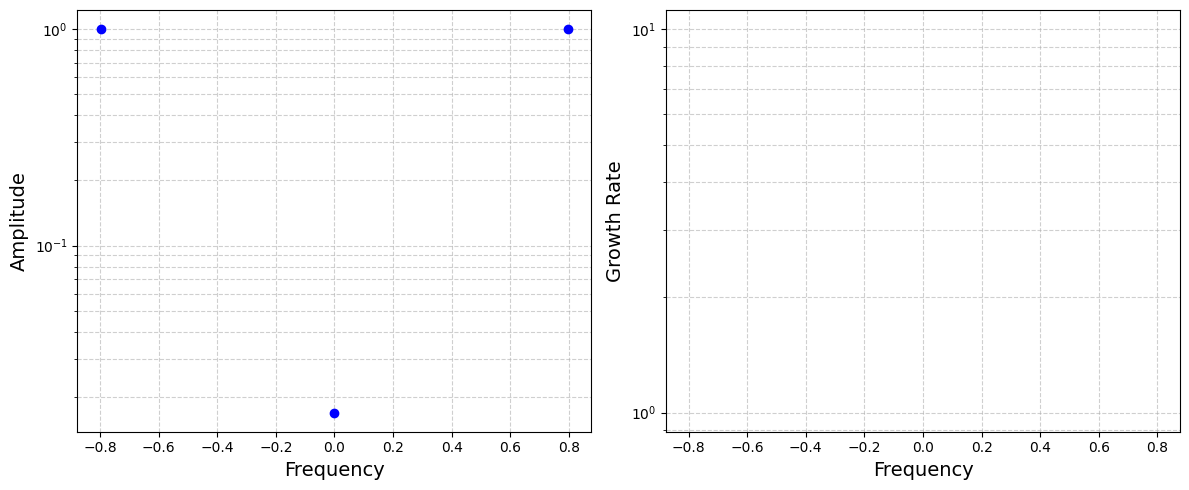

In [ ]:
fig_spec, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(Frequency, Amplitude / np.max(Amplitude), marker='o', color='b', linestyle='', markersize=6)
axes[0].set_yscale("log")
axes[0].set_xlabel("Frequency", fontsize=14)
axes[0].set_ylabel("Amplitude", fontsize=14)
axes[0].grid(True, which="both", linestyle="--", alpha=0.6)
axes[0].spines["top"].set_visible(True)
axes[0].spines["right"].set_visible(True)

# Growth Rate vs Frequency
axes[1].plot(Frequency, np.abs(GrowthRate), marker='o', color='r', linestyle='', markersize=6)
axes[1].set_yscale("log")
axes[1].set_xlabel("Frequency", fontsize=14)
axes[1].set_ylabel("Growth Rate", fontsize=14)
axes[1].grid(True, which="both", linestyle="--", alpha=0.6)
axes[1].spines["top"].set_visible(True)
axes[1].spines["right"].set_visible(True)

plt.tight_layout()
plt.show()

Plot Modes

/var/folders/7j/kcyj8x3j2b5_j6p2jr6h_ltw0000gn/T/ipykernel_24631/1588671933.py:3: UserWarning: The following kwargs were not used by contour: 'shading'
  im = plt.contourf(X, Y, np.real(moded[0,:,:]), cmap="viridis", shading="auto")


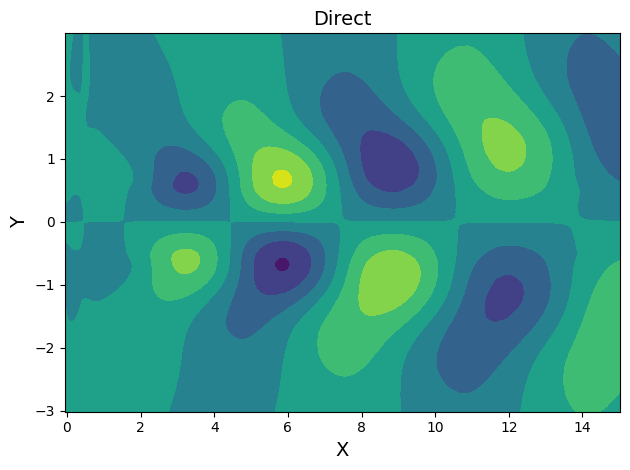

/var/folders/7j/kcyj8x3j2b5_j6p2jr6h_ltw0000gn/T/ipykernel_24631/1588671933.py:13: UserWarning: The following kwargs were not used by contour: 'shading'
  im = ax0.contourf(X, Y, np.real(modea[0,:,:]), cmap="viridis", shading="auto")


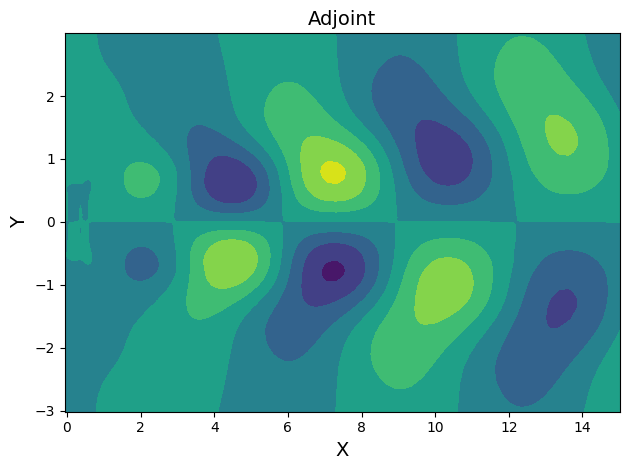

In [15]:
##### Plot direct mode #####
fig_dir, ax = plt.subplots()
im = plt.contourf(X, Y, np.real(moded[0,:,:]), cmap="viridis", shading="auto")
ax.set_title(f"Direct", fontsize=14)
ax.set_xlabel("X", fontsize=14)
ax.set_ylabel("Y", fontsize=14)

plt.tight_layout()
plt.show()

##### Plot adjoint mode #####
fig_adj, ax0 =  plt.subplots()
im = ax0.contourf(X, Y, np.real(modea[0,:,:]), cmap="viridis", shading="auto")
ax0.set_title(f"Adjoint", fontsize=14)
ax0.set_xlabel("X", fontsize=14)
ax0.set_ylabel("Y", fontsize=14)

plt.tight_layout()
plt.show()

Plot non-linear structural sensitivity

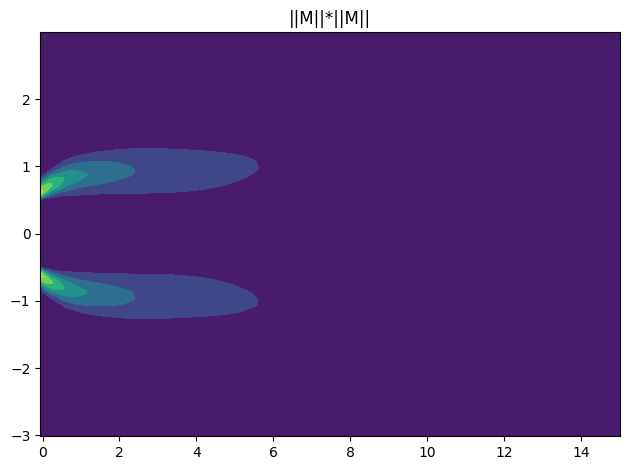

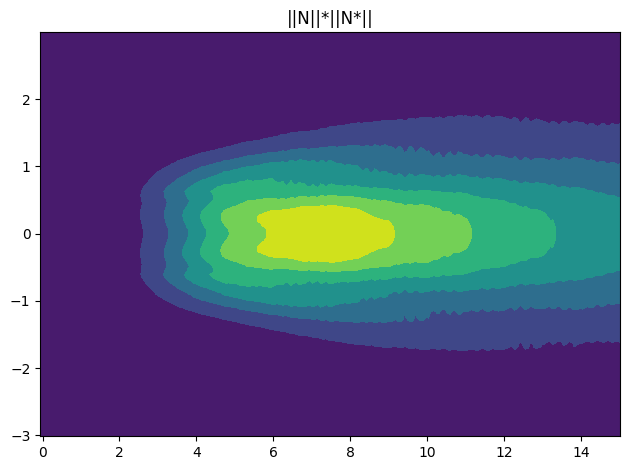

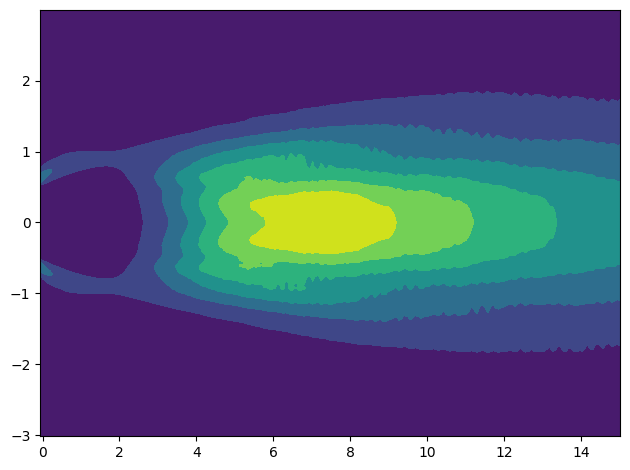

In [16]:
##### Plot first term #####
fig_MM,ax = plt.subplots()
plt.contourf(Malla[0,:,:],Malla[1,:,:],np.real(ff1)/np.amax(np.real(ff1)))
plt.title('||M||*||M||')
plt.tight_layout()
plt.show()

##### Plot second term #####
fig_NN,ax =  plt.subplots()
plt.contourf(Malla[0,:,:],Malla[1,:,:],ff2/np.amax(ff2))
plt.title('||N||*||N*||')
plt.tight_layout()
plt.show()

##### Plot non-linear structural sensitivity #####
fig_NL,ax =  plt.subplots()
plt.contourf(Malla[0,:,:],Malla[1,:,:],NLSens)
plt.tight_layout()
plt.show()
